In [1]:
import torch
import sys, os
sys.path.append('../')
import matplotlib.pyplot as plt
import seaborn as sns

import json
import pandas as pd
import numpy as np
import glob

## Task 1: maligant classifcation 
- FFDM: Linear classifier / locality-attention + linear classfier 
- US: MIL-attention + linear classfier 

In [2]:
sns.set_context("talk")
sns.set_style("whitegrid")
def plot_auc_learning_curve(logs, text):

    plt.figure(figsize=(8, 5))
    logs[logs['mode']=='val']['head4_auc'].plot(marker='o', use_index=False, alpha=0.6)

    highest = logs[logs['mode']=='val']['head4_auc'].max()
    epoch = logs[logs['mode']=='val']['head4_auc'].argmax()

    plt.scatter(y=highest, x=epoch, marker='*', color='r', s=300)
    plt.text(y=highest-0.001, x=epoch-1, text=f'highest AUC={highest:1.3f}', s=100)

    plt.ylabel('Test AUC '+text)
    plt.xlabel('epoch')
    plt.plot()

In [3]:
save_path = '/gpfs/data/geraslab/Nan/mmselfsup/work_dirs/benchmarks/classification/nyubreast/'

In [4]:
def get_lastest_runlogs(save_path, run_path):
    """gather the log of the lastest run and return log as data frame."""
    try:
        file = sorted(glob.glob(os.path.join(save_path, run_path, '*.json')))[-1]
        with open(file) as f:
            lines = f.readlines()[1:]
        logs = pd.DataFrame([json.loads(line) for line in lines])
    except:
        print(save_path, run_path)
        raise FileNotFoundError

    return logs

def get_comparison_table(modal_cls, model_path, exp_prefix, weight_init):
    performance = []
    for modal in modal_cls:
        for path in model_path:
            for exp in exp_prefix:
                for winit in weight_init:
                    try:
                        logs = get_lastest_runlogs(save_path, f'{modal}/{path}/{exp}{winit}')

                        loss, auc = logs[logs['mode']=='val'].head4_loss.min(),\
                                logs[logs['mode']=='val'].head4_auc.max() 

                        if 'head4_prauc' in logs.columns:
                            prauc = logs[logs['mode']=='val'].head4_prauc.max()   
                        else:
                            prauc = pd.NA

                        performance.append({'modal': modal, 'pretrain-exp': path,
                            'exp': exp, 
                            'weight init': winit.split('_')[-1] if winit!='' else 'cross-modal swav', 
                            'loss': loss, 'auc': auc, 'prauc': prauc})
                

                    except FileNotFoundError:
                        pass

    return pd.DataFrame(performance)



### FFDM:

#### Ablation study on the classifier complexity: Linear V.S. Linear +locality-attention

In [5]:
modal_cls = ['ffdm']
model_path = ['20220411_ffdm_latest.pth']
exp_prefix = ['balanced', 'locality_atten']
weight_init = ['', '_imagenet', '_randominit']

performance = get_comparison_table(modal_cls, model_path, exp_prefix, weight_init)
performance

,modal,pretrain-exp,exp,weight init,loss,auc,prauc
0,ffdm,20220411_ffdm_latest.pth,balanced,cross-modal swav,0.51060,0.57232,<NA>
1,ffdm,20220411_ffdm_latest.pth,balanced,imagenet,0.51911,0.55301,<NA>
2,ffdm,20220411_ffdm_latest.pth,balanced,randominit,0.54338,0.47133,<NA>
3,ffdm,20220411_ffdm_latest.pth,locality_atten,cross-modal swav,0.51121,0.59027,<NA>
4,ffdm,20220411_ffdm_latest.pth,locality_atten,imagenet,0.51882,0.56775,<NA>
5,ffdm,20220411_ffdm_latest.pth,locality_atten,randominit,0.51670,0.46325,<NA>


(0.4, 0.65)

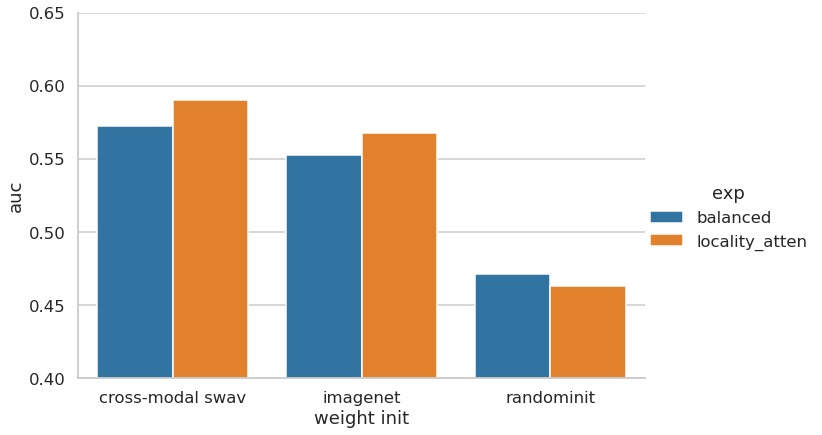

In [6]:
sns.set_context('talk')
sns.catplot(data=performance, y='auc', x='weight init', hue='exp', kind="bar", height=6, aspect=1.5)
plt.ylim(0.4, 0.65)

#### Ablantion study on the datasampler: fixed 4000 samples V.S. random negative samples per epoch

Basic configuration: Linear classifier +  locality-attention

In [7]:
modal_cls = ['ffdm', 'ffdm_fixed_datasampler', 'ffdm_biopsied_sampler']
model_path = ['20220411_ffdm_latest.pth']
exp_prefix = ['locality_atten']
weight_init = ['', '_imagenet', '_randominit']


performance = get_comparison_table(modal_cls, model_path, exp_prefix, weight_init)
performance

/gpfs/data/geraslab/Nan/mmselfsup/work_dirs/benchmarks/classification/nyubreast/ ffdm_biopsied_sampler/20220411_ffdm_latest.pth/locality_atten_imagenet
/gpfs/data/geraslab/Nan/mmselfsup/work_dirs/benchmarks/classification/nyubreast/ ffdm_biopsied_sampler/20220411_ffdm_latest.pth/locality_atten_randominit


,modal,pretrain-exp,exp,weight init,loss,auc,prauc
0,ffdm,20220411_ffdm_latest.pth,locality_atten,cross-modal swav,0.51121,0.59027,<NA>
1,ffdm,20220411_ffdm_latest.pth,locality_atten,imagenet,0.51882,0.56775,<NA>
2,ffdm,20220411_ffdm_latest.pth,locality_atten,randominit,0.51670,0.46325,<NA>
3,ffdm_fixed_datasampler,20220411_ffdm_latest.pth,locality_atten,cross-modal swav,0.50497,0.57900,<NA>
4,ffdm_fixed_datasampler,20220411_ffdm_latest.pth,locality_atten,imagenet,0.50243,0.57807,<NA>
5,ffdm_fixed_datasampler,20220411_ffdm_latest.pth,locality_atten,randominit,0.51483,0.46700,<NA>
6,ffdm_biopsied_sampler,20220411_ffdm_latest.pth,locality_atten,cross-modal swav,0.68967,0.57154,0.22682


#### Ablantion study on the FFDM resolution: 736x480 V.S. 1472x960

In [8]:
modal_cls = ['ffdm', 'ffdm_highresolution.py']
model_path = ['20220411_ffdm_latest.pth', 'ffdm_latest.pth']
exp_prefix = ['locality_atten']
weight_init = ['']



performance = get_comparison_table(modal_cls, model_path, exp_prefix, weight_init)
performance

/gpfs/data/geraslab/Nan/mmselfsup/work_dirs/benchmarks/classification/nyubreast/ ffdm/ffdm_latest.pth/locality_atten
/gpfs/data/geraslab/Nan/mmselfsup/work_dirs/benchmarks/classification/nyubreast/ ffdm_highresolution.py/20220411_ffdm_latest.pth/locality_atten


,modal,pretrain-exp,exp,weight init,loss,auc,prauc
0,ffdm,20220411_ffdm_latest.pth,locality_atten,cross-modal swav,0.51121,0.59027,<NA>
1,ffdm_highresolution.py,ffdm_latest.pth,locality_atten,cross-modal swav,0.50453,0.58517,<NA>


In [9]:
def learning_curves_comparsion(file_prefixes, titles): 
    fig, axs = plt.subplots(1, 4, figsize=(25, 4))
    for (modal, path, exp, winit), title  in zip(file_prefixes, titles):
        logs = get_lastest_runlogs(save_path, f'{modal}/{path}/{exp}{winit}')
        logs[logs['mode']=='train'].loss.rolling(100).mean().plot(
            use_index=False, label=title, ax=axs[0], alpha=0.5)

        axs[0].set_ylabel('train loss')
        axs[0].set_xlabel('epoch')
        axs[0].legend()

        logs[logs['mode']=='val'].head4_loss.plot(
            use_index=False, label=title, ax=axs[1])

        axs[1].set_ylabel('val loss')
        axs[1].set_xlabel('epoch')
        axs[1].legend()

        logs[logs['mode']=='val'].head4_auc.plot(
            use_index=False, label=title, ax=axs[2])

        axs[2].set_ylabel('val auc')
        axs[2].set_xlabel('epoch')
        axs[2].legend()
        if 'head4_prauc' in logs:

            logs[logs['mode']=='val'].head4_prauc.plot(
                use_index=False, label=title, ax=axs[3])

        axs[3].set_ylabel('val orauc')
        axs[3].set_xlabel('epoch')
        axs[3].legend()

    plt.show()


# file_prefixes = [('ffdm', '20220411_ffdm_latest.pth', 'ablation_reso', ''), 
#                  ('ffdm_highresolution', 'ffdm_latest.pth', 'ablation_reso', '')]
# titles = ['736x480', '1472x960']
# learning_curves_comparsion(file_prefixes, titles)



# file_prefixes = [('ffdm_biopsied_sampler', '20220411_ffdm_latest.pth', 'locality_atten', ''),
#                  ('ffdm_highresolution', 'ffdm_latest.pth', 'biopsied_sampler', '')]
# titles = ['736x480','1472x960', '1472x960']
# learning_curves_comparsion(file_prefixes, titles)

### Attention 


In [10]:
modal_cls = ['ffdm', 'ffdm_highresolution']
model_path = ['swav_resnet18_milatten1_batch128', 'ffdm_latest.pth']
exp_prefix = ['locality_atten', 'ablation_reso', 'pretrained_head', 'freeze_head']
weight_init = ['']


performance = get_comparison_table(modal_cls, model_path, exp_prefix, weight_init)
performance

/gpfs/data/geraslab/Nan/mmselfsup/work_dirs/benchmarks/classification/nyubreast/ ffdm/swav_resnet18_milatten1_batch128/ablation_reso
/gpfs/data/geraslab/Nan/mmselfsup/work_dirs/benchmarks/classification/nyubreast/ ffdm/ffdm_latest.pth/locality_atten
/gpfs/data/geraslab/Nan/mmselfsup/work_dirs/benchmarks/classification/nyubreast/ ffdm/ffdm_latest.pth/ablation_reso
/gpfs/data/geraslab/Nan/mmselfsup/work_dirs/benchmarks/classification/nyubreast/ ffdm/ffdm_latest.pth/pretrained_head
/gpfs/data/geraslab/Nan/mmselfsup/work_dirs/benchmarks/classification/nyubreast/ ffdm/ffdm_latest.pth/freeze_head
/gpfs/data/geraslab/Nan/mmselfsup/work_dirs/benchmarks/classification/nyubreast/ ffdm_highresolution/swav_resnet18_milatten1_batch128/locality_atten
/gpfs/data/geraslab/Nan/mmselfsup/work_dirs/benchmarks/classification/nyubreast/ ffdm_highresolution/swav_resnet18_milatten1_batch128/ablation_reso
/gpfs/data/geraslab/Nan/mmselfsup/work_dirs/benchmarks/classification/nyubreast/ ffdm_highresolution/swav

,modal,pretrain-exp,exp,weight init,loss,auc,prauc
0,ffdm,swav_resnet18_milatten1_batch128,locality_atten,cross-modal swav,0.50351,0.56625,0.22637
1,ffdm,swav_resnet18_milatten1_batch128,pretrained_head,cross-modal swav,0.50480,0.55923,0.22982
2,ffdm,swav_resnet18_milatten1_batch128,freeze_head,cross-modal swav,0.51139,0.51612,0.20761
3,ffdm_highresolution,ffdm_latest.pth,ablation_reso,cross-modal swav,0.49926,0.59388,0.23567


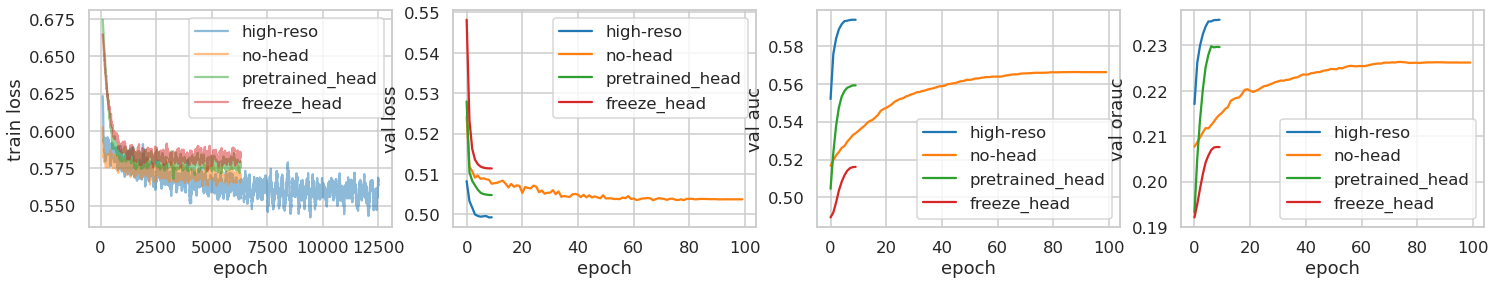

In [11]:
file_prefixes = [#('ffdm', '20220411_ffdm_latest.pth', 'ablation_reso', ''), 
                 ('ffdm_highresolution', 'ffdm_latest.pth', 'ablation_reso', ''),
                 ('ffdm', 'swav_resnet18_milatten1_batch128', 'locality_atten', ''), 
                 ('ffdm', 'swav_resnet18_milatten1_batch128', 'pretrained_head', ''), 
                 ('ffdm', 'swav_resnet18_milatten1_batch128', 'freeze_head', ''), 
                 ]
titles = [#'vanilla', 
'high-reso',  'no-head', 'pretrained_head', 'freeze_head']
learning_curves_comparsion(file_prefixes, titles)

In [37]:
modal_cls = ['ffdm']
model_path = ['swav_resnet18_milatten1_batch128', 'nyu_ffdm_screening/imagenet',
'nyu_ffdm_screening/swav_resnet18_milatten1_batch128', 
'nyu_ffdm_screening/swav_resnet18_avgpool_coslr-100e_largebatch_skynet-gpu32',
'nyu_ffdm_screening/swav_resnet18_milatten1_batch128/focalloss']
exp_prefix = ['locality_atten', 'pretrained_head_1e3', 'pretrained_head_1e2']
weight_init = ['']


performance = get_comparison_table(modal_cls, model_path, exp_prefix, weight_init)
performance


/gpfs/data/geraslab/Nan/mmselfsup/work_dirs/benchmarks/classification/nyubreast/ ffdm/swav_resnet18_milatten1_batch128/pretrained_head_1e3
/gpfs/data/geraslab/Nan/mmselfsup/work_dirs/benchmarks/classification/nyubreast/ ffdm/swav_resnet18_milatten1_batch128/pretrained_head_1e2
/gpfs/data/geraslab/Nan/mmselfsup/work_dirs/benchmarks/classification/nyubreast/ ffdm/nyu_ffdm_screening/imagenet/pretrained_head_1e3
/gpfs/data/geraslab/Nan/mmselfsup/work_dirs/benchmarks/classification/nyubreast/ ffdm/nyu_ffdm_screening/imagenet/pretrained_head_1e2
/gpfs/data/geraslab/Nan/mmselfsup/work_dirs/benchmarks/classification/nyubreast/ ffdm/nyu_ffdm_screening/swav_resnet18_avgpool_coslr-100e_largebatch_skynet-gpu32/pretrained_head_1e3
/gpfs/data/geraslab/Nan/mmselfsup/work_dirs/benchmarks/classification/nyubreast/ ffdm/nyu_ffdm_screening/swav_resnet18_avgpool_coslr-100e_largebatch_skynet-gpu32/pretrained_head_1e2
/gpfs/data/geraslab/Nan/mmselfsup/work_dirs/benchmarks/classification/nyubreast/ ffdm/nyu_

,modal,pretrain-exp,exp,weight init,loss,auc,prauc
0,ffdm,swav_resnet18_milatten1_batch128,locality_atten,cross-modal swav,0.50351,0.56625,0.22637
1,ffdm,nyu_ffdm_screening/imagenet,locality_atten,cross-modal swav,0.49031,0.60119,0.26041
2,ffdm,nyu_ffdm_screening/swav_resnet18_milatten1_bat...,locality_atten,cross-modal swav,0.49484,0.57319,0.24508
3,ffdm,nyu_ffdm_screening/swav_resnet18_milatten1_bat...,pretrained_head_1e3,cross-modal swav,0.49356,0.59477,0.27041
4,ffdm,nyu_ffdm_screening/swav_resnet18_milatten1_bat...,pretrained_head_1e2,cross-modal swav,0.49061,0.61030,0.28413
5,ffdm,nyu_ffdm_screening/swav_resnet18_avgpool_coslr...,locality_atten,cross-modal swav,0.49026,0.59144,0.25345
6,ffdm,nyu_ffdm_screening/swav_resnet18_milatten1_bat...,pretrained_head_1e2,cross-modal swav,0.56594,0.58905,0.25302


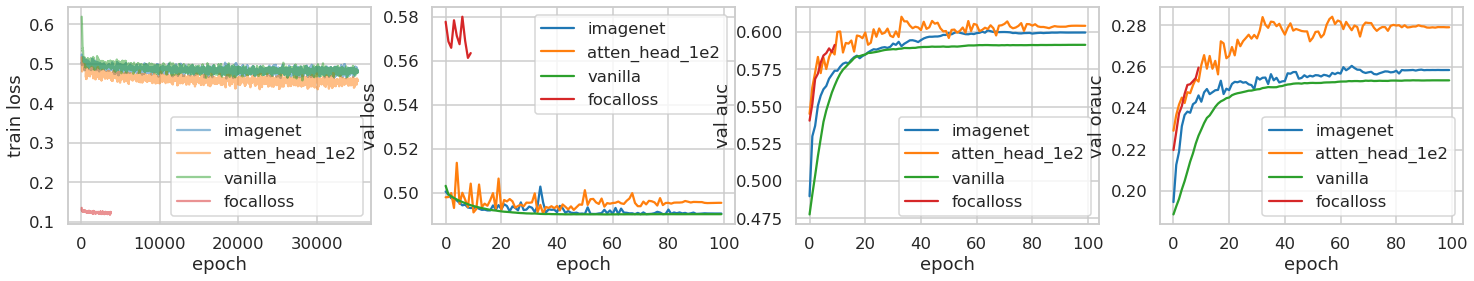

In [44]:
file_prefixes = [
        # ('ffdm', 'swav_resnet18_milatten1_batch128', 'locality_atten', ''),
         ('ffdm', 'nyu_ffdm_screening/imagenet', '', 'locality_atten'),
                # ('ffdm', 'nyu_ffdm_screening/swav_resnet18_milatten1_batch128', '', 'locality_atten'), 
                # ('ffdm', 'nyu_ffdm_screening/swav_resnet18_milatten1_batch128', '', 'pretrained_head_1e3'),
                ('ffdm', 'nyu_ffdm_screening/swav_resnet18_milatten1_batch128', '', 'pretrained_head_1e2'), 
                ('ffdm', 'nyu_ffdm_screening/swav_resnet18_avgpool_coslr-100e_largebatch_skynet-gpu32', '', 'locality_atten'),  
                #  ('ffdm', 'resnet50_imagenet_supervised', 'nyu_ffdm_screening', '')
                ('ffdm', 'nyu_ffdm_screening/swav_resnet18_milatten1_batch128/focalloss', '', 'pretrained_head_1e2'), 

                 ]
titles = [
        #'atten_small', 
'imagenet',  
#'atten', 
 #'atten_head_1e3', 
 'atten_head_1e2',
 'vanilla' , 
 #'resnet50',
 'focalloss'
 ]
learning_curves_comparsion(file_prefixes, titles)

In [41]:
modal_cls = ['ffdm']
model_path = ['resnet50_imagenet_supervised', 'nyu_ffdm_screening/imagenet',
'resnet18_imagenet_supervised', 'nyu_ffdm_screening_supervised']
exp_prefix = ['locality_atten', 
'train_nyu_ffdm_screening/eval/nyu_readerstudy_ffdm/1e-3', 
'nyu_ffdm_screening',
# 'train_nyu_ffdm_screening/eval/nyu_readerstudy_ffdm/1e-5', 
'eval_nyu_readerstudy/swav_resnet18_milatten1_batch128/1e-2',
'eval_nyu_readerstudy/swav_resnet18_milatten1_batch128/1e-3',
'eval_nyu_readerstudy/swav_resnet18_milatten1_batch128/1e-5',
'eval_nyu_readerstudy/swav_resnet18_milatten1_batch128/pretrained_head/1e-2',
'eval_nyu_readerstudy/swav_resnet18_milatten1_batch128/pretrained_head/1e-3',
]
weight_init = ['']


performance = get_comparison_table(modal_cls, model_path, exp_prefix, weight_init)
performance


/gpfs/data/geraslab/Nan/mmselfsup/work_dirs/benchmarks/classification/nyubreast/ ffdm/resnet50_imagenet_supervised/locality_atten
/gpfs/data/geraslab/Nan/mmselfsup/work_dirs/benchmarks/classification/nyubreast/ ffdm/resnet50_imagenet_supervised/train_nyu_ffdm_screening/eval/nyu_readerstudy_ffdm/1e-3
/gpfs/data/geraslab/Nan/mmselfsup/work_dirs/benchmarks/classification/nyubreast/ ffdm/resnet50_imagenet_supervised/eval_nyu_readerstudy/swav_resnet18_milatten1_batch128/1e-2
/gpfs/data/geraslab/Nan/mmselfsup/work_dirs/benchmarks/classification/nyubreast/ ffdm/resnet50_imagenet_supervised/eval_nyu_readerstudy/swav_resnet18_milatten1_batch128/1e-3
/gpfs/data/geraslab/Nan/mmselfsup/work_dirs/benchmarks/classification/nyubreast/ ffdm/resnet50_imagenet_supervised/eval_nyu_readerstudy/swav_resnet18_milatten1_batch128/1e-5
/gpfs/data/geraslab/Nan/mmselfsup/work_dirs/benchmarks/classification/nyubreast/ ffdm/resnet50_imagenet_supervised/eval_nyu_readerstudy/swav_resnet18_milatten1_batch128/pretrain

AttributeError: 'DataFrame' object has no attribute 'head4_loss'

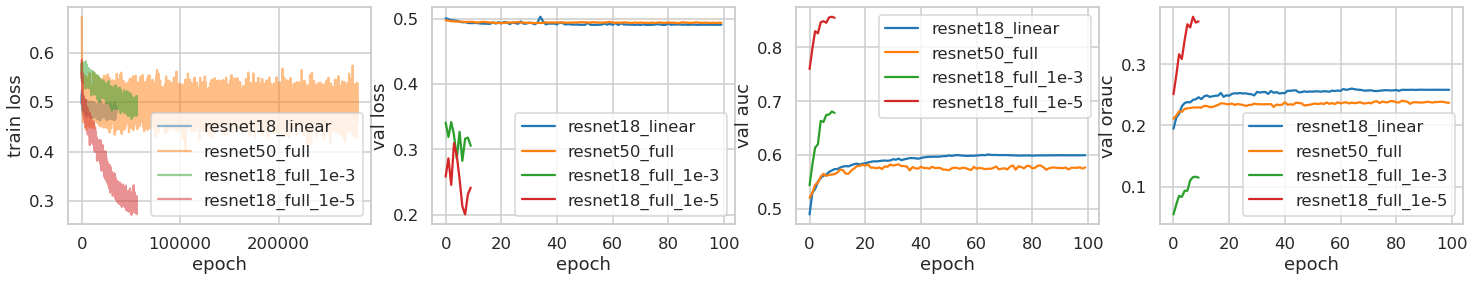

In [15]:
file_prefixes = [('ffdm', 'nyu_ffdm_screening/imagenet', '', 'locality_atten'),
                 ('ffdm', 'resnet50_imagenet_supervised', 'nyu_ffdm_screening', ''),
                 ('ffdm', 'resnet18_imagenet_supervised', 'train_nyu_ffdm_screening/eval/nyu_readerstudy_ffdm/', '1e-3'),
                 ('ffdm', 'resnet18_imagenet_supervised', 'train_nyu_ffdm_screening/eval/nyu_readerstudy_ffdm/', '1e-5'),
                 ]
titles = ['resnet18_linear', 'resnet50_full', 'resnet18_full_1e-3', 'resnet18_full_1e-5',]
learning_curves_comparsion(file_prefixes, titles)

AttributeError: 'DataFrame' object has no attribute 'head4_loss'

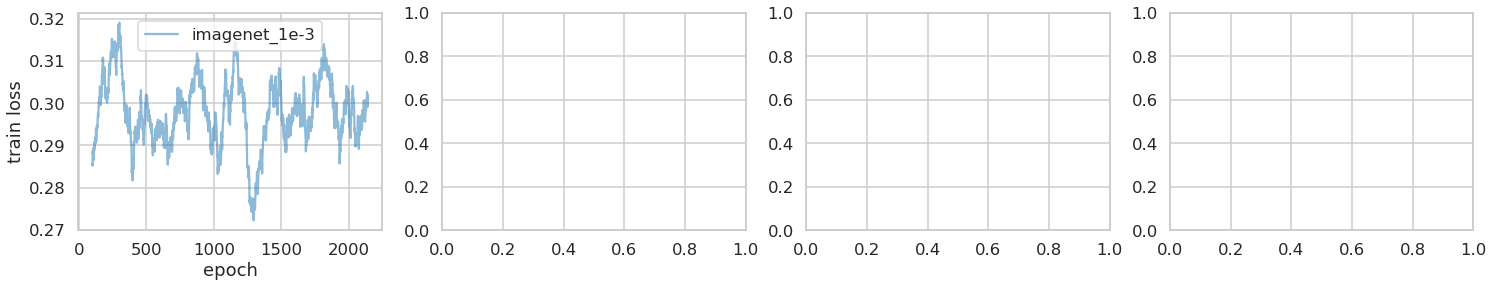

In [43]:
file_prefixes = [
                # ('ffdm', 'resnet18_imagenet_supervised', 'train_nyu_ffdm_screening/eval/nyu_readerstudy_ffdm/', '1e-3'),
                 ('ffdm', 'resnet18_imagenet_supervised', 'train_nyu_ffdm_screening/eval/nyu_readerstudy_ffdm/', '1e-5'),
                 ('ffdm', 'nyu_ffdm_screening_supervised', 'eval_nyu_readerstudy/swav_resnet18_milatten1_batch128/', '1e-3'),
                ('ffdm', 'nyu_ffdm_screening_supervised', 'eval_nyu_readerstudy/swav_resnet18_milatten1_batch128/', '1e-5'),
                 ('ffdm', 'nyu_ffdm_screening_supervised', 'eval_nyu_readerstudy/swav_resnet18_milatten1_batch128/', '1e-2'),

                # ('ffdm', 'nyu_ffdm_screening_supervised', 'eval_nyu_readerstudy/swav_resnet18_milatten1_batch128/pretrained_head/', '1e-3'),
                #  ('ffdm', 'nyu_ffdm_screening_supervised', 'eval_nyu_readerstudy/swav_resnet18_milatten1_batch128/pretrained_head/', '1e-2'),
                 
                 ]
titles = ['imagenet_1e-3', 'imagenet_1e-5', 'swav_atten_1e-3', 'swav_atten_1e-5', 'swav_atten_1e-2']
learning_curves_comparsion(file_prefixes, titles)

### Ultrasound

#### malignant prediction

In [24]:
modal_cls = ['us']
model_path = ['20220411_us_latest.pth']
exp_prefix = ['balanced', 'unfreeze_batch16']
weight_init = ['', '_imagenet', '_randominit', '_imagenet']

performance = get_comparison_table(modal_cls, model_path, exp_prefix, weight_init)
performance

AttributeError: 'DataFrame' object has no attribute 'head4_auc_micro'

#### nosiy label prediction

In [20]:
def learning_curves_comparsion(file_prefixes, titles): 
    fig, axs = plt.subplots(1, 4, figsize=(25, 4))
    for (modal, path, exp, winit), title  in zip(file_prefixes, titles):
        logs = get_lastest_runlogs(save_path, f'{modal}/{path}/{exp}{winit}')
        logs[logs['mode']=='train'].loss.rolling(50).mean().plot(
            use_index=False, label=title, ax=axs[0], alpha=0.5)

        axs[0].set_ylabel('train loss')
        axs[0].set_xlabel('epoch')
        axs[0].legend()

        logs[logs['mode']=='val'].head4_loss.plot(
            use_index=False, label=title, ax=axs[1])

        axs[1].set_ylabel('val loss')
        axs[1].set_xlabel('epoch')
        axs[1].legend()

        logs[logs['mode']=='val'].head4_auc_micro.plot(
            use_index=False, label=title, ax=axs[2])

        axs[2].set_ylabel('val auc')
        axs[2].set_xlabel('epoch')
        axs[2].legend()
        if 'head4_prauc_micro' in logs:

            logs[logs['mode']=='val'].head4_prauc_micro.plot(
                use_index=False, label=title, ax=axs[3])

        axs[3].set_ylabel('val orauc')
        axs[3].set_xlabel('epoch')
        axs[3].legend()

    plt.show()

def get_comparison_table(modal_cls, model_path, exp_prefix, weight_init):
    performance = []
    for modal in modal_cls:
        for path in model_path:
            for exp in exp_prefix:
                for winit in weight_init:
                    try:
                        logs = get_lastest_runlogs(save_path, f'{modal}/{path}/{exp}{winit}')
                    
                        loss, auc, prauc = logs[logs['mode']=='val'].head4_loss.min(),\
                                logs[logs['mode']=='val'].head4_auc_micro.max(),\
                                logs[logs['mode']=='val'].head4_prauc_micro.max()        

                        performance.append({'modal': modal, 'pretrain-exp': path,
                            'exp': exp, 
                            'weight init': winit.split('_')[-1] if winit!='' else 'cross-modal swav', 
                            'loss': loss, 'auc': auc, 'prauc': prauc})
                    except FileNotFoundError:
                        pass

    return pd.DataFrame(performance)

In [62]:
modal_cls = ['us_noisy_token']
model_path = ['20220411_us_latest.pth', 'swav_resnet18_milatten1_batch128']
exp_prefix = [ 'Adam1e2']
weight_init = ['', '_imagenet']

performance = get_comparison_table(modal_cls, model_path, exp_prefix, weight_init)
performance

AttributeError: 'DataFrame' object has no attribute 'head4_auc'

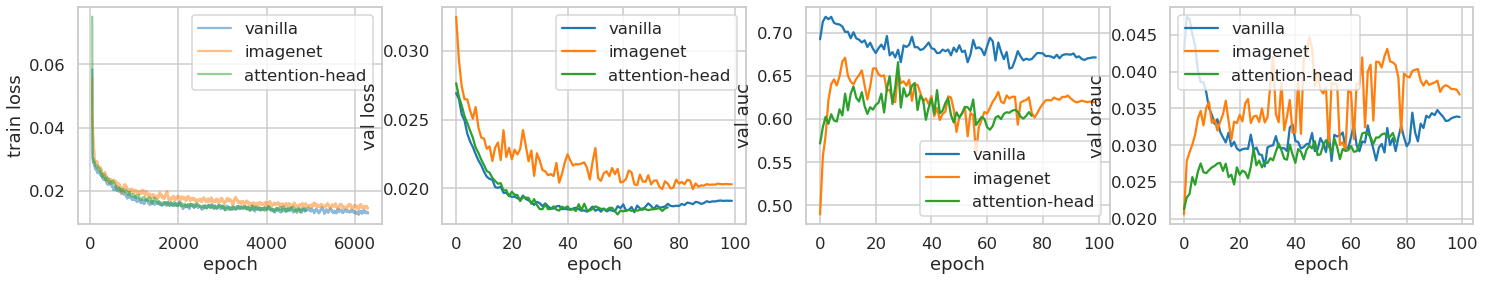

In [22]:
file_prefixes = [('us_noisy_token', '20220411_us_latest.pth', 'Adam1e2', ''),
                 ('us_noisy_token', '20220411_us_latest.pth', 'Adam1e2_imagenet', ''),
                 ('us_noisy_token', 'swav_resnet18_milatten1_batch128', 'Adam1e2', ''),
                 ]
titles = ['vanilla', 'imagenet', 'attention-head']
learning_curves_comparsion(file_prefixes, titles)